In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_retinal_disease_classification_path = kagglehub.dataset_download('andrewmvd/retinal-disease-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'retinal-disease-classification' dataset.
Data source import complete.


In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading image and label paths

In [3]:
DATA_ROOT = '/kaggle/input/retinal-disease-classification'

train_dir = os.path.join(DATA_ROOT, 'Training_Set', 'Training_Set')
val_dir = os.path.join(DATA_ROOT, 'Evaluation_Set', 'Evaluation_Set')
test_dir = os.path.join(DATA_ROOT, 'Test_Set', 'Test_Set')

train_img_paths = glob.glob(os.path.join(train_dir, 'Training', '*.png'))
train_label_path = os.path.join(train_dir, 'RFMiD_Training_Labels.csv')

val_img_paths = glob.glob(os.path.join(val_dir, 'Validation', '*.png'))
val_label_path = os.path.join(val_dir, 'RFMiD_Validation_Labels.csv')

test_img_paths = glob.glob(os.path.join(test_dir, 'Test', '*.png'))
test_label_path = os.path.join(test_dir, 'RFMiD_Testing_Labels.csv')

len(train_img_paths), len(val_img_paths), len(test_img_paths)

(1920, 640, 640)

In [4]:
train_label_df = pd.read_csv(train_label_path)
val_label_df = pd.read_csv(val_label_path)
test_label_df = pd.read_csv(test_label_path)

print(f'Num. train labels: {len(train_label_df)}')
print(f'Num. val labels: {len(val_label_df)}')
print(f'Num. test labels: {len(test_label_df)}')

Num. train labels: 1920
Num. val labels: 640
Num. test labels: 640


In [5]:
# show labels in train set
train_label_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`Important note:` the index to the dataframe for each iamge sample is its ID (also name) - 1. With this out of the way, I won't talk about this again in the code below

# Visualizing the dataset

There are 47 columns. Out of which, the `ID` column is the retina image ID, `Disease_Risk` is a binary column representing whether the retina is normal or not. The remaining 45 columns are different types of retina diseases

In [6]:
train_label_df.columns, len(train_label_df.columns)

(Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
        'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
        'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
        'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
        'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
       dtype='object'),
 47)

Since this is a `multi-label classification` problem, each sample might have zero, one, or more than one true labels. In this case, each retina image might have multiple diseases. Let's plot it out!

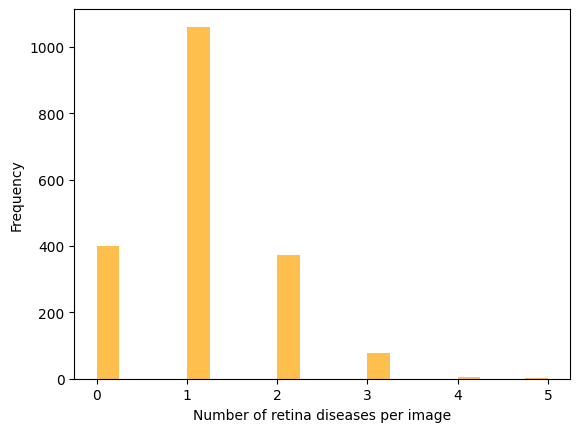

In [7]:
n_diseases_per_sample = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=1)

plt.hist(n_diseases_per_sample, bins=20, color='orange', alpha=0.7)
plt.xlabel('Number of retina diseases per image')
plt.ylabel('Frequency')
plt.show()

Let's plot a normal retinal image and one with 5 diseases to compare the differences

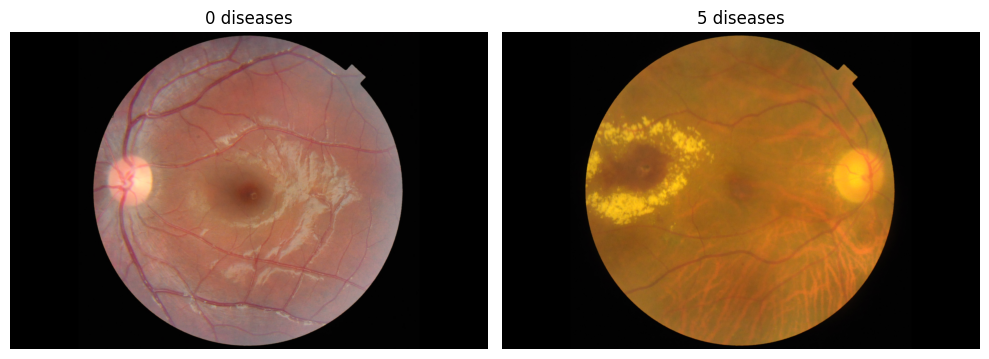

In [8]:
id_0di = (n_diseases_per_sample == 0).idxmax()
id_5di = (n_diseases_per_sample == 5).idxmax()

img_0di_path = os.path.join(train_dir, 'Training', f'{id_0di+1}.png')
img_5di_path = os.path.join(train_dir, 'Training', f'{id_5di+1}.png')

def load_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

img_0di, img_5di = load_img(img_0di_path), load_img(img_5di_path)

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_0di)
plt.title('0 diseases')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_5di)
plt.title('5 diseases')
plt.axis('off')

plt.tight_layout()
plt.show()

Now let's try from 0 to 5 diseases

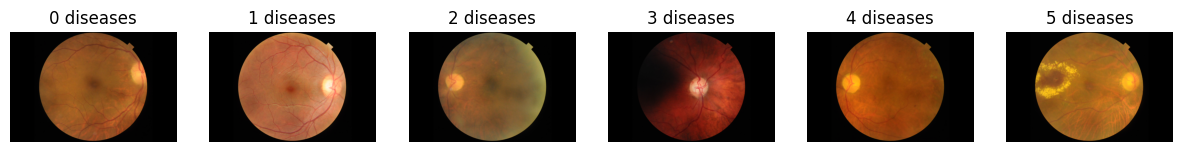

In [9]:
plt.figure(figsize=(15, 5))
np.random.seed(42)

for i in range(6):  # 0 to 5 diseases
    indices_i = n_diseases_per_sample.index[n_diseases_per_sample == i].tolist()
    if indices_i:
        id_i = np.random.choice(indices_i)  # Get a random index for the current disease count
        img_i_path = os.path.join(train_dir, 'Training', f'{id_i+1}.png')
        img_i = load_img(img_i_path)

        plt.subplot(1, 6, i + 1)
        plt.imshow(img_i)
        plt.title(f'{i} diseases')
        plt.axis('off')

plt.show()

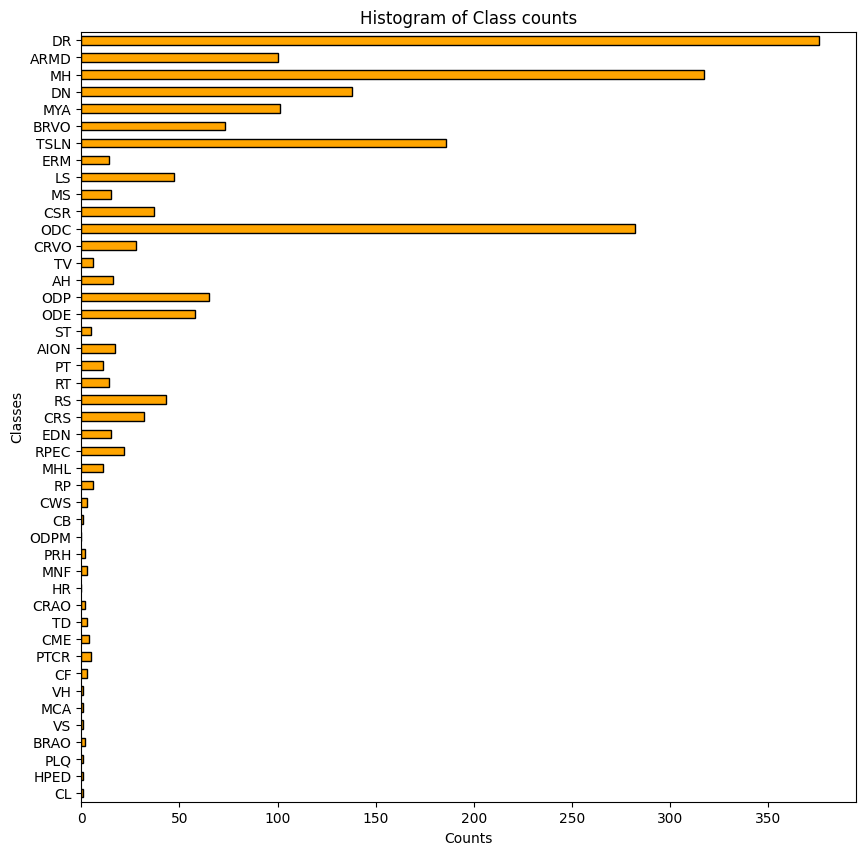

In [10]:
classes_freq = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=0)[::-1]

plt.figure(figsize=(10, 10))  # Adjust the width and height as needed
classes_freq.plot(kind='barh', color='orange', edgecolor='black')

plt.title('Histogram of Class counts')
plt.xlabel('Counts')
plt.ylabel('Classes')

plt.show()

There are some columns with zero appearance of positive samples so we will need to remove them during training

In [11]:
classes_freq.loc[classes_freq == 0]

,0
HR,0
ODPM,0


# Preprocessing data for training models

In [12]:
from torch.utils.data import Dataset
from PIL import Image

def path2id(img_path):
    return int(os.path.splitext(os.path.basename(img_path))[0])

class RetinaDataset(Dataset):

    def __init__(self, img_paths, label_csv_path, transform=None):
        self.img_paths = sorted(img_paths)
        self.label_df = pd.read_csv(label_csv_path).drop(columns=['ID', 'Disease_Risk', 'HR', 'ODPM'])
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, id):
        img_path = self.img_paths[id]
        img_id = path2id(img_path)
        img = Image.open(img_path)
        label = np.array(self.label_df.iloc[img_id - 1]) # Index to frame is image ID - 1, see the note earlier
        if self.transform is not None:
            img = self.transform(img)
            label = torch.from_numpy(label).float()
        else:
            img = np.array(img)
        return img, label

In [13]:
# test the dataset correctness, without transform
ID = 0

data = RetinaDataset(train_img_paths, train_label_path)

img, label = data[ID]
img.shape, img.dtype, label.shape, label.dtype

((1424, 2144, 3), dtype('uint8'), (43,), dtype('int64'))

Below we test out some transformations that PyTorch offers and visualize the result

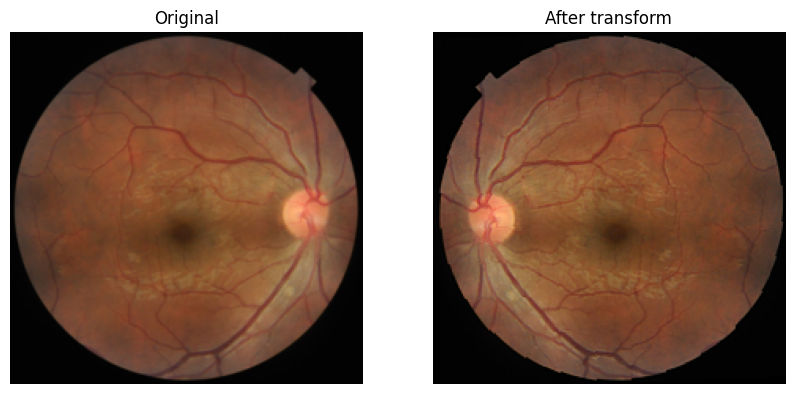

In [14]:
import torchvision.transforms.v2 as transforms

img_path = train_img_paths[8]
img = Image.open(img_path)

tf1 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

tf2 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 1),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
])

img1, img2 = tf1(img), tf2(img)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original')
plt.imshow(img1)

plt.subplot(122)
plt.title('After transform')
plt.imshow(img2)
plt.axis('off')
plt.show()

In [15]:
(np.array(img1) != np.array(img2)).sum()

np.int64(122737)

In [18]:
# pretrained means, stds, and transforms are given in pytorch official implementation of ConvNeXt
# https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_tiny.html#torchvision.models.convnext_tiny

import torchvision.transforms.v2 as transforms

PRET_MEANS = [0.485, 0.456, 0.406]
PRET_STDS = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 0.8),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

In [19]:
train_data = RetinaDataset(train_img_paths, train_label_path, train_transform)
val_data = RetinaDataset(val_img_paths, val_label_path, test_transform)
test_data = RetinaDataset(test_img_paths, test_label_path, test_transform)

img, label = train_data[ID]
img.shape, img.dtype, label.shape, label.dtype

(torch.Size([3, 224, 224]), torch.float32, torch.Size([43]), torch.float32)

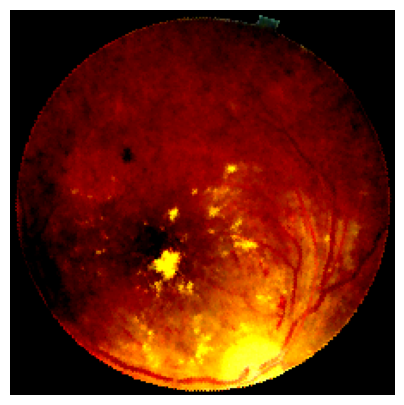

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()

In [21]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
# WEIGHT_DECAY = 1e-5
N_WORKERS = os.cpu_count()

train_loader = DataLoader(train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=N_WORKERS,
                           pin_memory=True)

val_loader = DataLoader(val_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

# Model configuration

In [22]:
!wget https://download.pytorch.org/models/resnet18-f37072fd.pth -O resnet18.pth

--2025-10-07 03:28:34--  https://download.pytorch.org/models/resnet18-f37072fd.pth
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.113, 3.165.102.31, 3.165.102.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46830571 (45M) [application/x-www-form-urlencoded]
Saving to: ‘resnet18.pth’

resnet18.pth        100%[===================>]  44.66M   209MB/s    in 0.2s    

2025-10-07 03:28:34 (209 MB/s) - ‘resnet18.pth’ saved [46830571/46830571]



In [25]:
from torchvision import models
from torch import nn
import torch

# 1. Create a ResNet18 model without pretrained weights
model = models.resnet18(weights=None)

# 2. Load pretrained weights downloaded earlier
state_dict = torch.load("resnet18.pth", map_location="cpu")
model.load_state_dict(state_dict)

# 3. Change the fully connected layer (classifier) to match the task (43 classes)
in_final = model.fc.in_features
OUT_FINAL = 43
model.fc = nn.Linear(in_final, OUT_FINAL)

print(model.fc)

Linear(in_features=512, out_features=43, bias=True)


In [24]:
# Number of parameters
sum(p.numel() for p in model.parameters())

25557032

# Finding suitable Learning Rate

With learning rate annealing from the paper https://arxiv.org/abs/1506.01186

In [26]:
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm

START_LR = 1e-7

optimizer = optim.AdamW(model.parameters(), lr=START_LR)
loss_fn = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

class LRFinder:

    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def _train_batch(self, iterator):
        self.model.train()
        self.optimizer.zero_grad()
        x, y = iterator.get_batch()
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred = model(x)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def range_test(self, iterator, end_lr=10, num_iter=100,
                    smooth_f=0.05, diverge_th=5):
        lrs=[]
        losses=[]
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)

        for iteration in tqdm(range(num_iter)):
            loss = self._train_batch(iterator)
            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
        return lrs, losses

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        cur_iter = self.last_epoch
        r = cur_iter / self.num_iter
        return [base_lr * ((self.end_lr / base_lr) ** r) for base_lr in self.base_lrs]

class IteratorWrapper():
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)
        return inputs, labels

    def get_batch(self):
        return next(self)

In [27]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, loss_fn, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


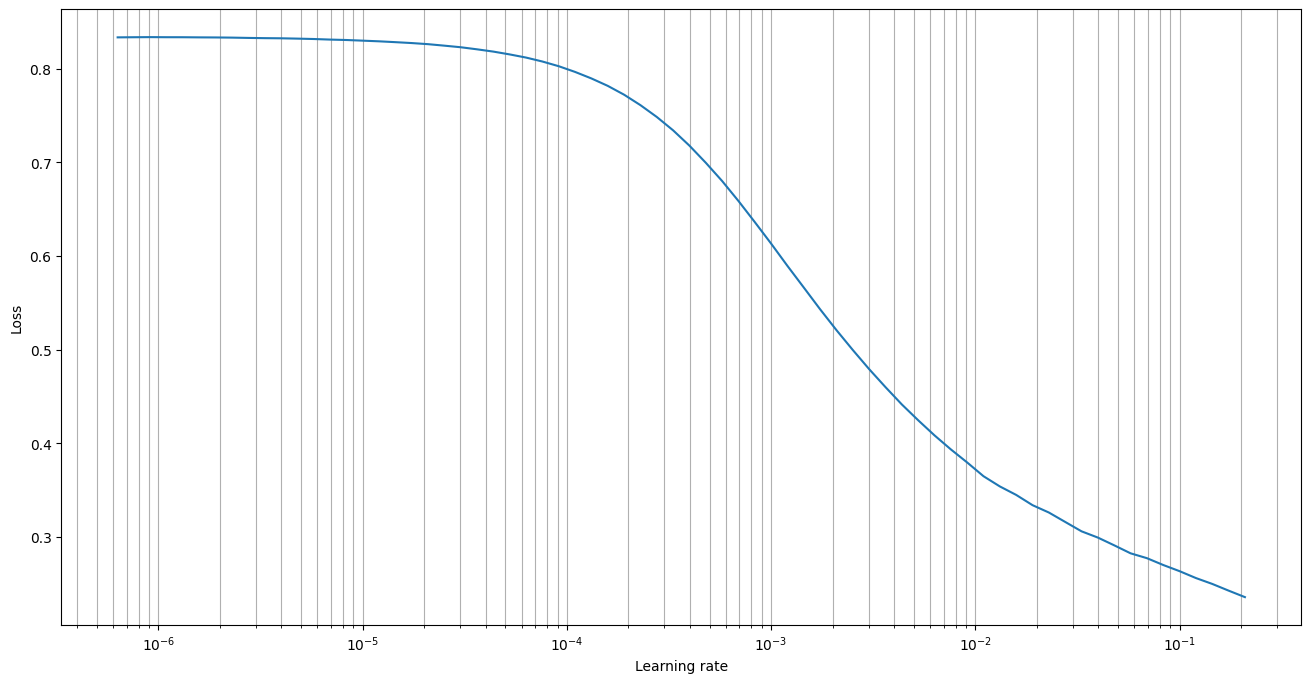

In [28]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

As explained in the paper, the recommended LR should be the place where the loss is lowest divided by 10. In this case, the suitable LR should be 2e-3

# Training model

We will also use `discriminative fine-tuning` from the paper https://arxiv.org/abs/1801.06146

In [29]:
LR_FOUND = 2e-3

loss_fn = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

# ใช้พารามิเตอร์ของ feature extractor กับ classifier ให้ถูกต้อง
lr_params = [
    {'params': model.layer1.parameters(), 'lr': LR_FOUND / 10},
    {'params': model.layer2.parameters(), 'lr': LR_FOUND / 10},
    {'params': model.layer3.parameters(), 'lr': LR_FOUND / 10},
    {'params': model.layer4.parameters(), 'lr': LR_FOUND / 10},
    {'params': model.fc.parameters(), 'lr': LR_FOUND}
]

optimizer = optim.AdamW(lr_params)


We'll use precision, recall, and (macro) F1 score as our evaluation metrics

In [30]:
def accuracy(y_h, y):
    y_h = (y_h > 0.5).float()
    return (y_h == y).float().mean(dim=1).mean()

def train_epoch(model, loader, loss_fn, optimizer, device, epoch):
    model.train()
    lossi, acci = [], []

    for x, y in tqdm(loader, desc=f'Epoch {epoch}'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        loss = loss_fn(y_h, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

        y_h, y = y_h.detach().cpu(), y.detach().cpu()
        acc = accuracy(y_h, y)
        acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

def eval(model, loader, loss_fn, device):
    model.eval()
    lossi, acci = [], []

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            loss = loss_fn(y_h, y)
            lossi.append(loss.item())

            y_h, y = y_h.detach().cpu(), y.detach().cpu()
            acc = accuracy(y_h, y)
            acci.append(acc)

    loss = torch.tensor(lossi).mean().item()
    acc = torch.tensor(acci).mean().item()
    return {'loss': loss, 'acc': acc}

In [31]:
N_EPOCHS = 25
best_loss = float('inf')

train_resi, val_resi = [], []
BEST_MODEL = ''

no_improvement_count = 0
max_no_improvement = 3  # Set the threshold for consecutive epochs without improvement

for epoch in range(N_EPOCHS):
    train_res = train_epoch(model, train_loader, loss_fn, optimizer, device, epoch+1)
    val_res = eval(model, val_loader, loss_fn, device)

    print('- Train')
    print(f"  Loss: {train_res['loss']: 3.4f} | "
          f"Accuracy: {train_res['acc']: .3f}")

    print('- Validation')
    print(f"  Loss: {val_res['loss']: 3.4f} | "
          f"Accuracy: {val_res['acc']: .3f}")

    val_loss = val_res['loss']

    if val_loss < best_loss:
        best_loss = val_loss
        BEST_MODEL = f'convnext_cp_{epoch+1}.pth'
        torch.save(model.state_dict(), BEST_MODEL)
        print('* Current best loss. Saved model!')
        no_improvement_count = 0  # Reset the counter since there's an improvement
    else:
        no_improvement_count += 1

    if no_improvement_count >= max_no_improvement:
        print(f'No improvement in validation loss for {max_no_improvement} consecutive epochs. Stopping training.')
        break

    train_resi.append(train_res)
    val_resi.append(val_res)

Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


- Train
  Loss:  0.1237 | Accuracy:  0.967
- Validation
  Loss:  0.0811 | Accuracy:  0.977
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


- Train
  Loss:  0.0587 | Accuracy:  0.981
- Validation
  Loss:  0.0659 | Accuracy:  0.980
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


- Train
  Loss:  0.0514 | Accuracy:  0.983
- Validation
  Loss:  0.0641 | Accuracy:  0.981
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


- Train
  Loss:  0.0451 | Accuracy:  0.984
- Validation
  Loss:  0.0602 | Accuracy:  0.981
* Current best loss. Saved model!


Evaluation: 100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


- Train
  Loss:  0.0411 | Accuracy:  0.985
- Validation
  Loss:  0.0667 | Accuracy:  0.980


Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


- Train
  Loss:  0.0378 | Accuracy:  0.986
- Validation
  Loss:  0.0639 | Accuracy:  0.981


Evaluation: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

- Train
  Loss:  0.0357 | Accuracy:  0.987
- Validation
  Loss:  0.0635 | Accuracy:  0.981
No improvement in validation loss for 3 consecutive epochs. Stopping training.


# Model evaluation

In [32]:
model.load_state_dict(torch.load(BEST_MODEL))

<All keys matched successfully>

In [33]:
import json

SAVE_RES = {
    'train': train_resi,
    'val': val_resi
}

with open('convnext_retina_result.json', 'w') as f:
    json.dump(SAVE_RES, f)

In [34]:
def true_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    true_positive = torch.sum((y_pred == 1) & (y_true == 1), dim=0)
    return true_positive

def false_positive(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_positive = torch.sum((y_pred == 1) & (y_true == 0), dim=0)
    return false_positive

def false_negative(y_pred, y_true, th=0.5):
    assert y_pred.shape == y_true.shape
    y_pred = (y_pred > th).float()
    false_negative = torch.sum((y_pred == 0) & (y_true == 1), dim=0)
    return false_negative

In [35]:
# test function correctness
y_true = torch.tensor([[0,1,1,0], [0,1,0,1]])
y_pred = torch.tensor([[0,1,0,1], [1,0,0,1]])

print('True positive:', true_positive(y_pred, y_true))
print('False positive:', false_positive(y_pred, y_true))
print('False negative:', false_negative(y_pred, y_true))

True positive: tensor([0, 1, 0, 1])
False positive: tensor([1, 0, 0, 1])
False negative: tensor([0, 1, 1, 0])


For our model result, we would want a high recall and a good precision as as missed diagnosis is bad while a wrong prediction might not be so life-threatening

In [36]:
true_pos, false_pos, false_neg = torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL)

model.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        y_h = model(x)
        y_h, y = y_h.detach().cpu(), y.detach().cpu()

        tp = true_positive(y_h, y)
        fp = false_positive(y_h, y)
        fn = false_negative(y_h, y)

        true_pos += tp; false_pos += fp; false_neg += fn

Evaluation: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


In [37]:
precision = true_pos / (true_pos + false_pos + 1e-10)
precision

tensor([0.8051, 0.6296, 0.8500, 0.5000, 0.8065, 0.8571, 0.8667, 0.0000, 1.0000,
        0.0000, 0.0000, 0.4815, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [38]:
recall = true_pos / (true_pos + false_neg + 1e-10)
recall

tensor([0.7197, 0.4474, 0.6667, 0.0652, 0.7353, 0.2609, 0.2000, 0.0000, 0.0588,
        0.0000, 0.0000, 0.1806, 0.1250, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3571, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [39]:
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
f1

tensor([0.7600, 0.5231, 0.7473, 0.1154, 0.7692, 0.4000, 0.3250, 0.0000, 0.1111,
        0.0000, 0.0000, 0.2626, 0.2222, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5263, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

# Final evaluation on the test set

In [40]:
def eval3(model, loader, device):
    true_pos, false_pos, false_neg = torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL), torch.zeros(OUT_FINAL)

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation on 3 metrics'):
            x, y = x.to(device), y.to(device)
            y_h = model(x)
            y_h, y = y_h.detach().cpu(), y.detach().cpu()

            tp = true_positive(y_h, y)
            fp = false_positive(y_h, y)
            fn = false_negative(y_h, y)

            true_pos += tp; false_pos += fp; false_neg += fn

    precision = true_pos / (true_pos + false_pos + 1e-10)
    recall = true_pos / (true_pos + false_neg + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return {
        'precision': precision, 'recall': recall, 'f1': f1
    }

test_result = eval3(model, test_loader, device)

Evaluation on 3 metrics: 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


In [41]:
test_result['precision']

tensor([0.8989, 0.7222, 0.7835, 1.0000, 0.9200, 0.7857, 0.7500, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6774, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [42]:
test_result['recall']

tensor([0.6452, 0.4194, 0.7308, 0.0217, 0.7188, 0.4783, 0.2264, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2308, 0.1111, 0.0000, 0.0000, 0.0000, 0.4706, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2143, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [43]:
test_result['f1']

tensor([0.7512, 0.5306, 0.7562, 0.0426, 0.8070, 0.5946, 0.3478, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3443, 0.2000, 0.0000, 0.0000, 0.0000, 0.6400, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [44]:
test_res = eval(model, test_loader, loss_fn, device)

Evaluation: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


In [45]:
print('- Test')
print(f"  Loss: {test_res['loss']: 3.4f} | "
      f"Accuracy: {test_res['acc']: .3f}")

- Test
  Loss:  0.0562 | Accuracy:  0.983


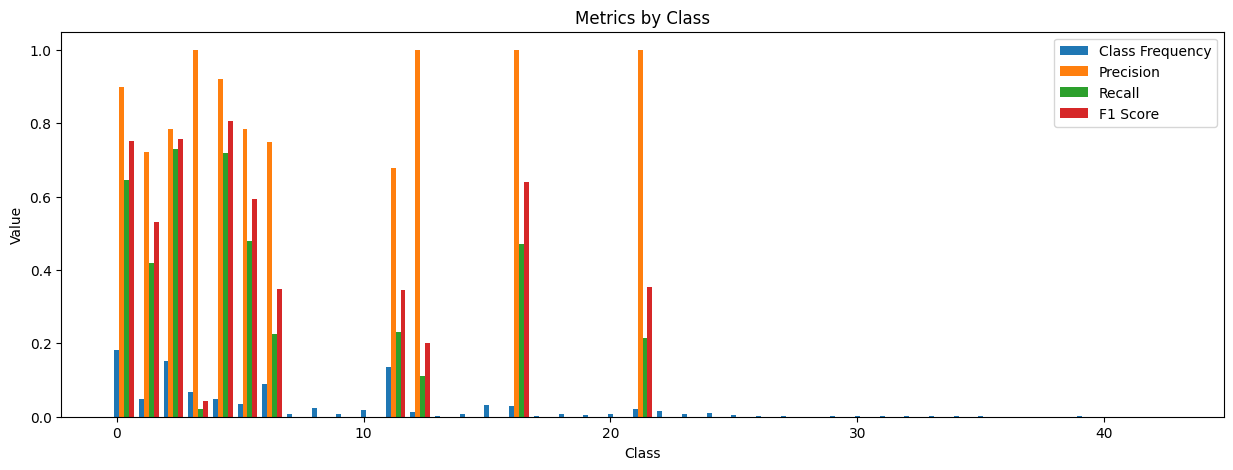

In [46]:
bar_width = 0.2
index = np.arange(OUT_FINAL)
classes_count = classes_freq.drop(['HR', 'ODPM'])
classes_prob = classes_count / classes_count.sum()
classes_prob = classes_prob[::-1]

# Plotting the bars
plt.figure(figsize=(15,5))
plt.bar(index, classes_prob, width=bar_width, label='Class Frequency')
plt.bar(index + 1 * bar_width, test_result['precision'], width=bar_width, label='Precision')
plt.bar(index + 2 * bar_width, test_result['recall'], width=bar_width, label='Recall')
plt.bar(index + 3 * bar_width, test_result['f1'], width=bar_width, label='F1 Score')

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('Metrics by Class')
plt.legend()

From the chart, we can see that when the amount of data is decent the model performs prety well around 70% in F1 score. However, when the amount of data is small, there are two cases. The first one is that the model can still perform pertty well but Recall is far lower than Precision. The second case is that the model doens't learn about these classes at all. This problem welcomes further investigation. That's it for now, thank you!

Generating predictions for confusion matrix: 100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


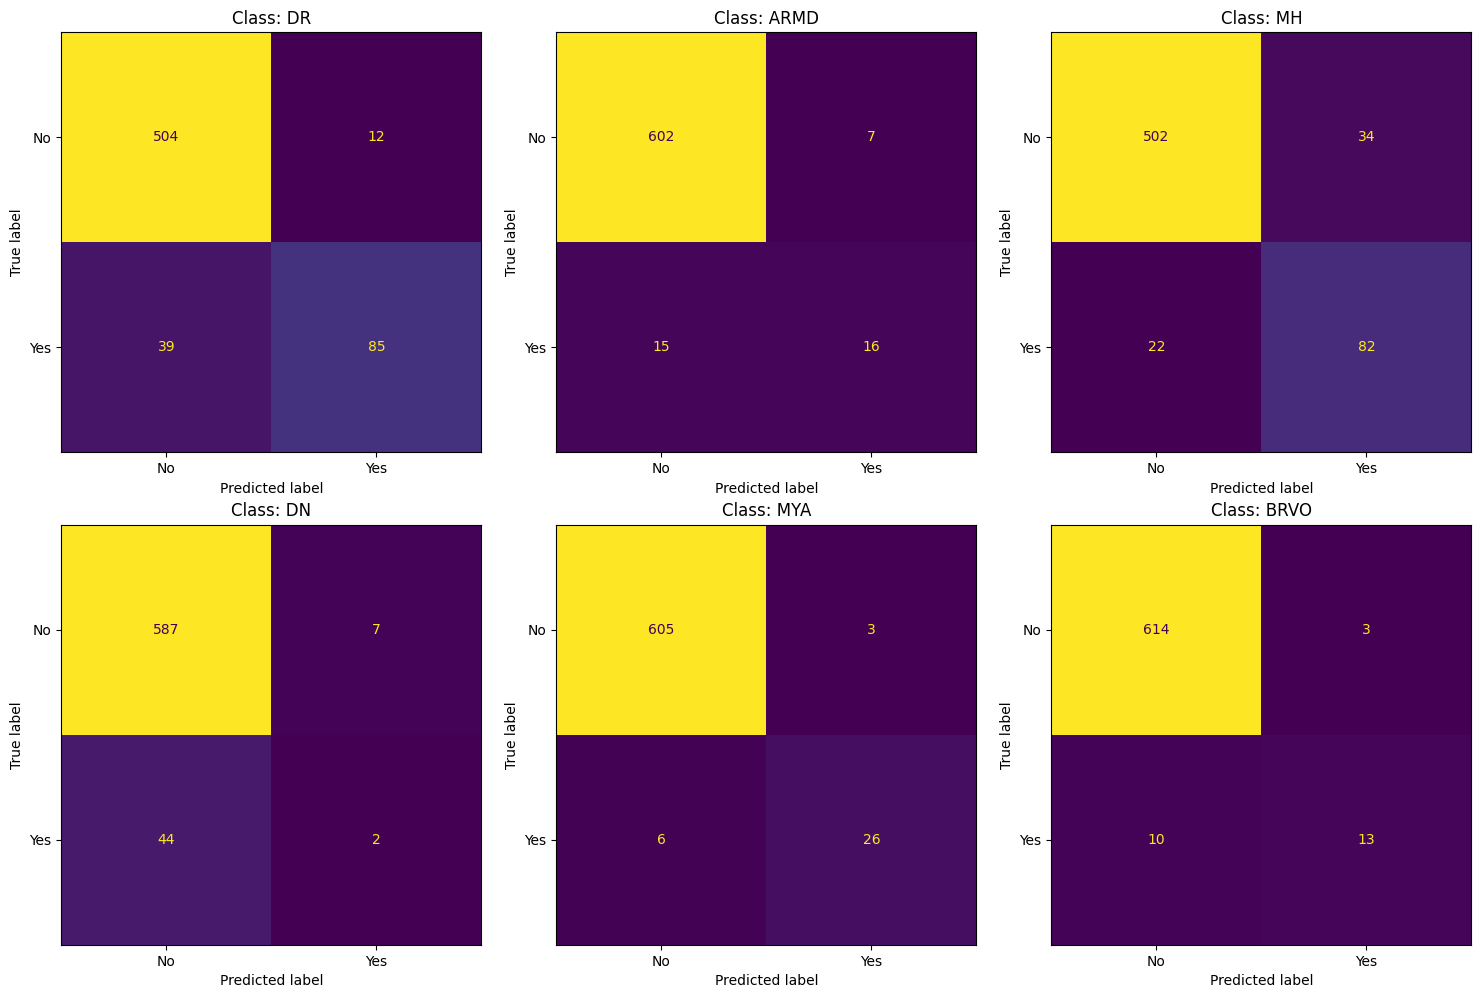

In [47]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and labels from the test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Generating predictions for confusion matrix'):
        x = x.to(device)
        y_h = model(x)

        # Convert logits to probabilities and then to binary predictions
        preds = (torch.sigmoid(y_h) > 0.5).float()

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Get class names, excluding the ones dropped in the dataset
class_names = train_label_df.drop(columns=['ID', 'Disease_Risk', 'HR', 'ODPM']).columns

# Calculate the multilabel confusion matrix
mcm = multilabel_confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrices for each class
# We will display a few examples as plotting all 43 would be too cluttered.
n_classes_to_show = 6
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (matrix, ax) in enumerate(zip(mcm[:n_classes_to_show], axes.flatten())):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No', 'Yes'])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f'Class: {class_names[i]}')

plt.tight_layout()
plt.show()